In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#importing fast.ai library
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.torch_imports import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd

In [4]:
#Path of the dataset and size of each image
PATH = "data/Dog_Breed_Identification/"
sz = 224

In [5]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

### Data allocation and data preprocessing

In [6]:
os.listdir(PATH)

['labels.csv',
 'labels.csv.zip',
 'models',
 'sample_submission.csv.zip',
 'test',
 'test.zip',
 'tmp',
 'train',
 'train.zip']

In [7]:
files = os.listdir(f'{PATH}/train')
files[:10]

['82e5e207ea4080bb7bb1cf0371dd38eb.jpg',
 '000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '002211c81b498ef88e1b40b9abf84e1d.jpg',
 '00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '002a283a315af96eaea0e28e7163b21b.jpg',
 '003df8b8a8b05244b1d920bb6cf451f9.jpg']

In [8]:
#Lenth of training set data i.e. no of training images=
len(files)

10224

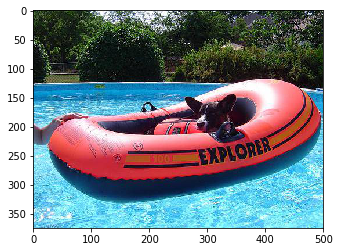

In [9]:
img = plt.imread(f'{PATH}train/{files[0]}')
plt.imshow(img)

In [10]:
df = pd.read_csv(f'{PATH}/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
labels_csv = f'{PATH}labels.csv'
n = len(list(open(labels_csv))) - 1
val_idx = get_cv_idxs(n)

In [12]:
#Obtaining dataframe which consists of total count of each bread of dog.
dogLabelsAggregated = pd.pivot_table(data=df,index='breed',aggfunc=len).sort_values('id',ascending=False)
dogLabelsAggregated

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


### Implementing actual model.

In [13]:
arch = resnet50
tmfs = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
data = ImageClassifierData.from_csv(path=PATH,folder='train',csv_fname=f'{PATH}/labels.csv',test_name='test',
                                    bs=4,tfms=tmfs,val_idxs = val_idx,suffix='.jpg')
learn = ConvLearner.pretrained(arch,data,precompute=True)
learn.fit(0.01,2)

epoch      trn_loss   val_loss   accuracy                     
    0      1.521579   0.623849   0.813601  
    1      1.190973   0.580401   0.819472                      



[array([0.5804]), 0.8194716242661448]

In [14]:
# accuracy for are pretrained model = 80.6751
# Now lets find suitable LR using CLR and SGDR.
lrf = learn.lr_find()

 63%|██████▎   | 1281/2045 [00:05<00:03, 235.10it/s, loss=3.3]  


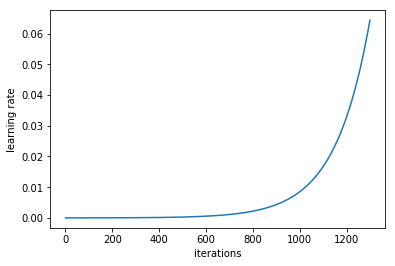

In [15]:
learn.sched.plot_lr()

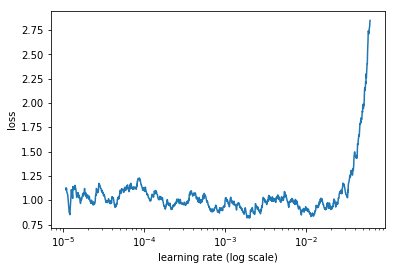

In [16]:
learn.sched.plot()

In [17]:
#Now lets use different learning rate i.e. 1e-03
learn.fit(1e-3,6)

epoch      trn_loss   val_loss   accuracy                       
    0      0.931993   0.470773   0.85274   
    1      0.709486   0.472939   0.856654                       
    2      0.709333   0.458426   0.856654                       
    3      0.816404   0.459939   0.857632                       
    4      0.799943   0.442695   0.863992                       
    5      0.583398   0.452683   0.8591                         



[array([0.45268]), 0.8590998043052838]

In [18]:
learn.precompute = False

In [19]:
learn.fit(1e-3,3,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.785889   0.437063   0.863014  
    1      0.825359   0.446386   0.856654                      
    2      0.673115   0.447222   0.860078                      



[array([0.44722]), 0.860078277886497]

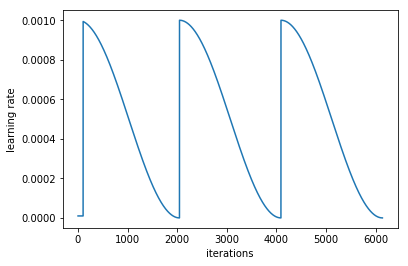

In [20]:
learn.sched.plot_lr()

In [21]:
learn.save('224_lastlayer_dogBreedIden')

In [22]:
learn.load('224_lastlayer_dogBreedIden')

### Fine tuning and differential learning rate 

In [23]:
learn.unfreeze()

In [24]:
lr = np.array([1e-10,1e-5,1e-3])

In [25]:
learn.fit(lr,2,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      1.638433   0.617602   0.823875  
    1      1.47018    0.633947   0.813601                     
    2      1.290264   0.538441   0.843444                     



[array([0.53844]), 0.8434442270058709]

### Visualizing the data

In [26]:
data.val_y

array([ 19,  15,   7, ..., 109,   3,  28])

In [27]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


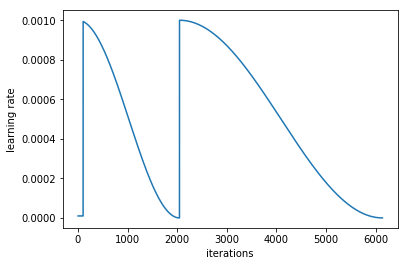

In [28]:
learn.sched.plot_lr()

In [29]:
logs_preds = learn.predict()

In [30]:
logs_preds.shape

(2044, 120)